# Setting

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain_openai langchain_experimental langsmith pandas

In [2]:
%%capture --no-stderr
%pip install -U --quiet langchain-community tiktoken langchain-openai langchainhub chromadb langchain langgraph langchain-text-splitters

In [3]:
# 환경변수 불러오기
import getpass
import os

def _set_env(var: str):
    ''' 환경변수에 없으면 입력 받을 수 있게하는 함수 '''
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [196]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0) # gpt-4-turbo, gpt-4o-realtime-preview, gpt-4o-mini, gpt-4o

# Supervisor Node

- supervisor = LLM 노드 
- Agent Router를 통해 적절한 에이전트를 라우팅하고, 작업 완료 여부 결정함.

In [197]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from pydantic import BaseModel
from typing import Literal


# =========================[ 작업자 그룹 정의, 결정된 작업자 반환 양식 정의 ]==================================
# members = ["조사자", "상담사"]
members = ["Researcher"] # , "Counselor"
options = ["FINISH"] + members

class RouteResponse(BaseModel):
    next: Literal[*options]


# =========================[ 수퍼바이저 시스템 프롬프트 ]==================================
# 한국어 프롬프트를 사용하려면 members 이름도 한국어로 해야함. 그리고 추가 설명도 해줘야 잘됨.
# 영어로 할 때는 그냥 기본 프롬프트 쓰는게 더 잘됨. 추가 설명해주니까 오히려 틀림.
# system_prompt = (
#     "당신은 대화를 관리하는 관리자(Supervisor) 역할을 맡고 있으며, {members}라는 작업자 그룹을 감독하게 됩니다. " 
#     "사용자 요청을 기반으로, 다음 작업을 수행할 작업자를 선택해 주세요. "
#     "만약 사용자의 메시지가 정보 요청과 같은 질문 형태라면 '조사자'를 선택하세요. "
#     "예를 들어, 진로, 직업 정보, 전공 또는 대학 정보 등과 같이 정보를 물어보는 질문일 경우 '조사자'가 적절합니다. "
#     "반대로, 사용자의 메시지가 상담사의 질문에 대한 답변 형태라면 '상담사'를 선택하세요. "
#     "각 작업자는 자신의 작업을 완료한 후 결과와 상태를 보고할 것입니다. "
#     "모든 작업(task)이 완료되면 'FINISH'로 응답해 주세요."
# )
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "위 대화 내용을 바탕으로, 다음에 행동해야 할 작업자(worker)는 누구인가요? 또는 작업을 종료할 것인가요?"
            "다음 옵션 중 하나를 선택해 주세요: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


# =========================[ 수퍼바이저 정의 ]==================================
def supervisor_agent(state):
    """Supervisor가 대화의 흐름을 제어하고 다음 작업을 수행할 에이전트를 선택"""
    # 수퍼바이저(체인) : 시스템 프롬프트 + 반환 양식 
    # LLM을 통해 적합한 작압자 선정한 후 양식에 맞게 반환.
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)
    return supervisor_chain.invoke(state)

### [TEST] Supervisor

---

In [183]:
def test_supervisor(query):    
    # 테스트를 위한 상태(state)를 설정 (사용자 메시지 시뮬레이션)
    state = {
        "messages": [
            {"role": "user", "content": query},  # 사용자 질문
        ]
    }

    # 수퍼바이저 에이전트 호출
    response = supervisor_agent(state)
    
    # 결과 출력
    print(f"Supervisor 선택: {response.next}")

In [184]:
# 진로상담 질의 -> Counselor
# 이전 상담사 질문 가정 : 어떤 활동을 할 때 흥미를 느끼나요?
query = "저는 무언가를 만드는 것을 좋아합니다. 특히 컴퓨터로 프로그램을 만드는것이 재밌는 것 같아요"
test_supervisor(query)

Supervisor 선택: Researcher


In [185]:
# 진로정보검색 질의 -> Researcher
test_supervisor("AI 엔지니어가 되려면 무엇을 준비해야 할까요?")

Supervisor 선택: Researcher


---

# Agent State

- `state` 객체는 그래프의 각 노드에 전달되는 상태.
- state는 `messages`의 리스트가 됨.
- 그래프의 각 노드가 여기에 추가됨. 

In [198]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# Annotated는 Python 타입 힌팅에 사용되는 유틸리티, 첫 번째 인자 : 실제 타입, 두 번째 인자 : 타입이 어떻게 사용되거나 처리될지 정보
# Sequence[BaseMessage] -> BaseMessage 객체를 담고 있는 시퀀스 타입(리스트, 튜플)
# Annotated[]의 두 번째 인자 기본값은 replace
# operator.add : 파이썬 기본 덧셈 연산, 여기서는 새로운 메시지가 추가될 때 기존 메시지 리스트에 더해져서 관리됨.
# add_messages : LangGraph 상태 관리에 특화된 방식으로 메시지 추가(대화턴에 HumanMessage로 감싸진 대화가 추가됨)
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    next: str # 다음 라우팅할 곳

### [TEST] Langgraph add_messsages VS Python operator.add

---

In [187]:
from operator import add
from typing import List
from langgraph.graph.message import add_messages

# 기존 메시지 리스트
messages = ["Message 1", "Message 2"]

# operator.add로 메시지 추가
added_messages_operator = add(messages, ["New Message using operator.add"])


# add_messages 방식으로 메시지 추가
added_messages_custom = add_messages(messages, ["New Message using add_messages"])

# 두 결과를 출력하여 비교
print("operator.add 방식 결과:", added_messages_operator)
print("add_messages 방식 결과:", added_messages_custom)

operator.add 방식 결과: ['Message 1', 'Message 2', 'New Message using operator.add']
add_messages 방식 결과: [HumanMessage(content='Message 1', additional_kwargs={}, response_metadata={}, id='4a2f5404-8442-4cbc-a1b4-4ff48a135543'), HumanMessage(content='Message 2', additional_kwargs={}, response_metadata={}, id='e6c954bf-f835-4662-ad60-9373a62a25e7'), HumanMessage(content='New Message using add_messages', additional_kwargs={}, response_metadata={}, id='fb0a9057-290e-4822-b2af-d125dd334212')]


---

# Tools

In [ ]:
# 스크래핑한 마크다운 파일로부터 벡터 DB 구축
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain.text_splitter import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.llms import OpenAI


# UnstructuredMarkdownLoader를 사용하여 마크다운 파일을 로드합니다.
file_path
loader = UnstructuredMarkdownLoader(file_path)
documents = loader.load()

# MarkdownHeaderTextSplitter를 사용하여 헤더를 기준으로 청크로 분할
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]
splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on, strip_headers=False)
split_docs = splitter.split_documents(documents)

# 청크를 문자 수 기준으로 다시 분할하는 부분
chunk_size=1000
chunk_overlap=100
text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
split_docs = text_splitter.split_documents(documents)

# Chroma 벡터 스토어 설정
embeddings = OpenAIEmbeddings()  # OpenAI의 임베딩 모델 사용
persist_dir = "" # 벡터 DB 저장경로
vectorstore = Chroma.from_documents(
    documents=split_docs,
    collection_name="rag-chroma",
    embeddings=embeddings, 
    persist_directory=persist_dir
)

retriever = vectorstore.as_retriever(
    search_type="similarity", # 유사도 검색 방식
    search_kwargs={"k": 5} # 상위 탑 K 유사 문서 반환
)  


# test
from langchain.chains import RetrievalQA
llm = OpenAI(model="gpt-3.5-turbo")  # OpenAI의 GPT 모델 사용
qa_chain = RetrievalQA.from_chain_type(llm, retriever=retriever, chain_type="stuff")

# 예시 쿼리
query = "Markdown이란 무엇인가요?"
result = qa_chain.run(query)
print(result)

In [199]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools.retriever import create_retriever_tool


# 웹 검색 도구
tavily_tool = TavilySearchResults(max_results=5)

# 벡터 DB 검색 도구


# Helper Utilities

In [200]:
from langchain_core.messages import HumanMessage


# 에이전트 호출하고, 그 결과 state를 HummanMessage 형식으로 변환
# 에이전트가 생성한 응답을 사용자에게 전달하기 위함
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

# Construct Graph

## Define Worker(작업자) Node

In [201]:
import functools
from langgraph.prebuilt import create_react_agent # 단순히 자동으로 에이전트 만들어줌(커스터마이징 X)


research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

## Define Workflow

In [202]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("supervisor", supervisor_agent)

# Worker가 작업을 완료하면 항상 Supervisor에게 Report Back(보고) 하는 구조로 설계
for member in members:
    workflow.add_edge(member, "supervisor")
    
# Supervisor은 노드로 라우팅되거나 완료되는 그래프 State의 'next' 필드를 채움.
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

# entrypoint를 추가
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

# Display Graph

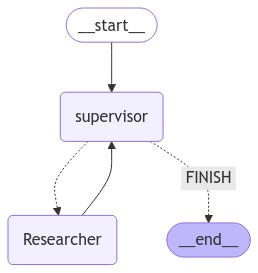

In [203]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # 여기에는 몇 가지 추가 종속성이 필요하며 선택 사항
    pass

# Invoke

In [204]:
for s in graph.stream({
    "messages": [
        HumanMessage(content="데이터 사이언티스트가 되고 싶은데 관련된 전공은 어떤게 있는지 각 대학별로 구분지어서 간단히 리스트업 해줘")
    ]
}):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='### 대학별 데이터 사이언스 관련 전공 리스트:\n\n#### Stanford University:\n- [Data Science (B.S.) and Data Science & Social Systems (B.A.) majors](https://datasciencemajor.stanford.edu/)\n- Stanford Data Science (SDS) community for research, application, and education\n- Undergraduate B.S. Program focusing on training versatile data scientists\n\n#### Harvard University:\n- [Master of Science (SM) degree in Data Science](https://www.harvard.edu/programs/data-science/)\n- Program covers reproducible data analysis, collaborative problem solving, visualization, and more\n- Joint academic leadership in Computer Science and Statistics faculties\n\n#### MIT:\n- [MIT IDSSx offers online data science courses](https://idss.mit.edu/academics/idssx/)\n- Applied Data Science Program: Leveraging AI for Effective Decision-Making\n- Statistics and Data Science Center for research and education programs\n\n#### University of

# Result

## Supervisor + Web Search Tool

---

### 대학별 데이터 사이언스 관련 전공 리스트:

#### Stanford University:
- [Data Science (B.S.) and Data Science & Social Systems (B.A.) majors](https://datasciencemajor.stanford.edu/)
- Stanford Data Science (SDS) community for research, application, and education
- Undergraduate B.S. Program focusing on training versatile data scientists

#### Harvard University:
- [Master of Science (SM) degree in Data Science](https://www.harvard.edu/programs/data-science/)
- Program covers reproducible data analysis, collaborative problem solving, visualization, and more
- Joint academic leadership in Computer Science and Statistics faculties

#### MIT:
- [MIT IDSSx offers online data science courses](https://idss.mit.edu/academics/idssx/)
- Applied Data Science Program: Leveraging AI for Effective Decision-Making
- Statistics and Data Science Center for research and education programs

#### University of California, Berkeley:
- [Data Science Major](https://cdss.berkeley.edu/dsus/academics) in the College of Letters & Science
- Data science modules for hands-on engagement with relevant data sets
- HCE Program for core courses in the Data Science major and minor

이렇게 대학별로 데이터 사이언스 관련 전공 정보를 요약해 보았습니다. 각 대학의 공식 웹사이트에서 더 자세한 정보를 확인할 수 있습니다.

---

In [ ]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Write a brief research report on pikas.")]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("----")